In [101]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Lambda
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import os
#### INSTRUCTIONS FOR I/O (PLEASE READ) #######
# Input data files are available in the read-only "../input/" (relative) or '/kaggle/input'(absolute) directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
input_path = '/Users/federicatonti/Desktop/dataset/'
output_path = '/Users/federicatonti/Desktop/working_GAN/'

In [102]:
tf.keras.utils.set_random_seed(812)

# This will make TensorFlow ops as deterministic as possible, but it will
# affect the overall performance, so it's not enabled by default.
# `enable_op_determinism()` is introduced in TensorFlow 2.9.
tf.config.experimental.enable_op_determinism()

In [103]:
#read file ids and file names for train and val data
train_df = pd.read_csv(input_path+'train.csv')
val_df= pd.read_csv(input_path+'val.csv')
#print 5 rows of pandas dataframe
train_df.head()

,id,dx_m,rho_filename,ux_filename,uy_filename,uz_filename
0,-5634614311666768042,0.000041,RHO_kgm-3_id-5634614311666768042.dat,UX_ms-1_id-5634614311666768042.dat,UY_ms-1_id-5634614311666768042.dat,UZ_ms-1_id-5634614311666768042.dat
1,-2337253536160728058,0.000041,RHO_kgm-3_id-2337253536160728058.dat,UX_ms-1_id-2337253536160728058.dat,UY_ms-1_id-2337253536160728058.dat,UZ_ms-1_id-2337253536160728058.dat
2,-7056668419406715714,0.000041,RHO_kgm-3_id-7056668419406715714.dat,UX_ms-1_id-7056668419406715714.dat,UY_ms-1_id-7056668419406715714.dat,UZ_ms-1_id-7056668419406715714.dat
3,-9138984573931233156,0.000041,RHO_kgm-3_id-9138984573931233156.dat,UX_ms-1_id-9138984573931233156.dat,UY_ms-1_id-9138984573931233156.dat,UZ_ms-1_id-9138984573931233156.dat
4,2699082921033192879,0.000041,RHO_kgm-3_id2699082921033192879.dat,UX_ms-1_id2699082921033192879.dat,UY_ms-1_id2699082921033192879.dat,UZ_ms-1_id2699082921033192879.dat


Text(0.5, 1.0, 'Z-Velocity')

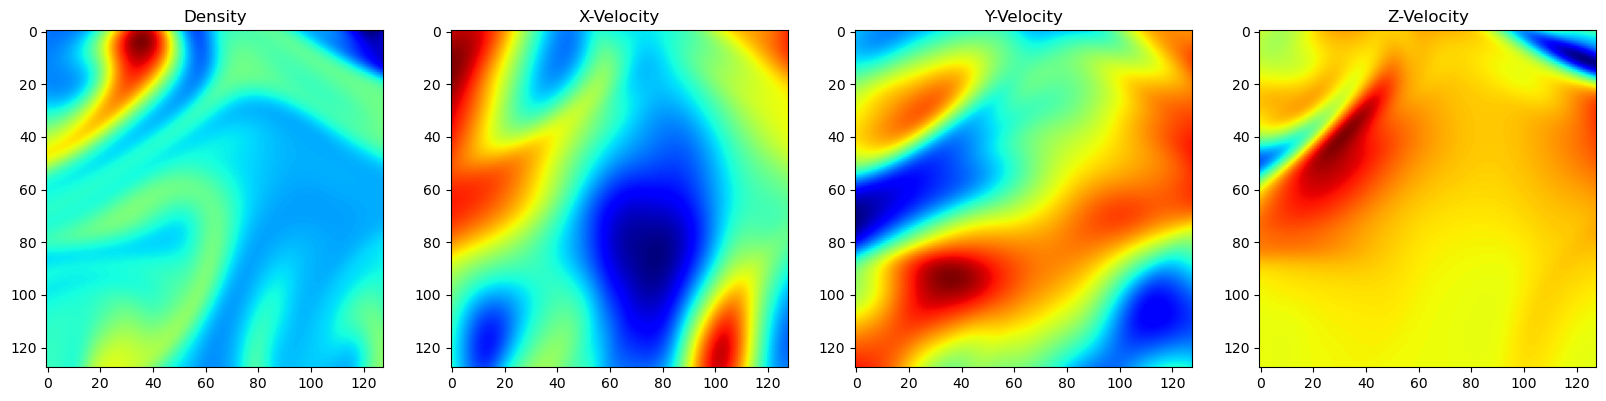

In [104]:
#plot HR labels

idx = 20
data_path = input_path+"flowfields/HR/train"
RHO_filename = train_df['rho_filename'][idx]
UX_filename = train_df['ux_filename'][idx]
UY_filename = train_df['uy_filename'][idx]
UZ_filename = train_df['uz_filename'][idx]
RHO = np.fromfile(data_path + "/" + RHO_filename, dtype="<f4")
UX = np.fromfile(data_path + "/" + UX_filename, dtype="<f4")
UY = np.fromfile(data_path + "/" + UY_filename, dtype="<f4")
UZ = np.fromfile(data_path + "/" + UZ_filename, dtype="<f4")

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].imshow(RHO.reshape(128, 128), cmap='jet')
axs[0].set_title('Density')
axs[1].imshow(UX.reshape(128, 128), cmap='jet')
axs[1].set_title('X-Velocity')
axs[2].imshow(UY.reshape(128, 128), cmap='jet')
axs[2].set_title('Y-Velocity')
axs[3].imshow(UZ.reshape(128, 128), cmap='jet')
axs[3].set_title('Z-Velocity')

Text(0.5, 1.0, 'UZ')

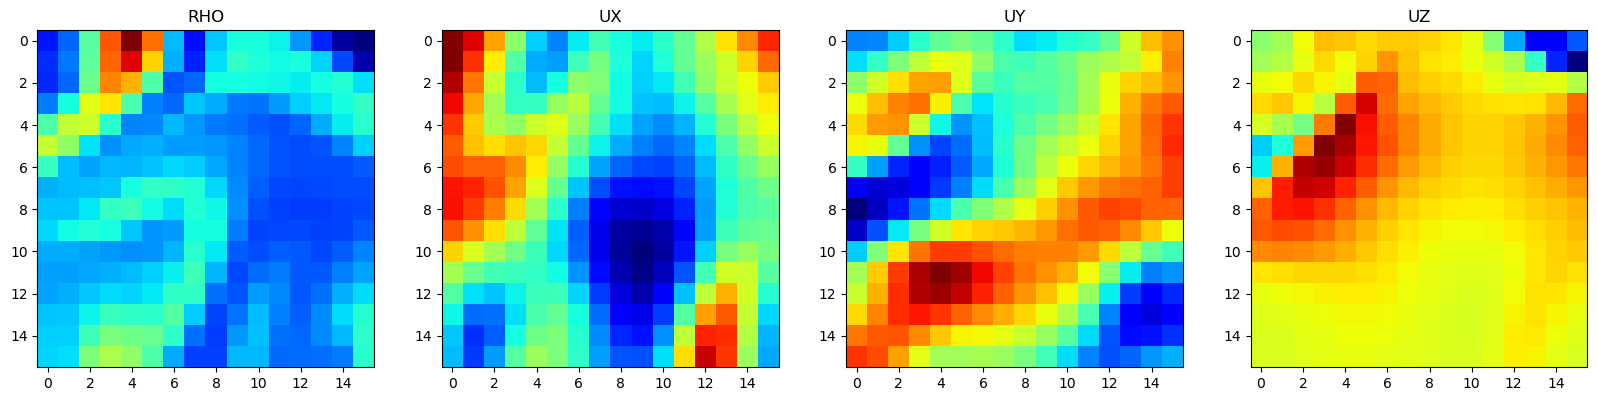

In [105]:
#plot LR features

id = 20
data_path = input_path+"flowfields/LR/train"
RHO_filename = train_df['rho_filename'][id]
UX_filename = train_df['ux_filename'][id]
UY_filename = train_df['uy_filename'][id]
UZ_filename = train_df['uz_filename'][id]
RHO = np.fromfile(data_path + "/" + RHO_filename, dtype="<f4")
UX = np.fromfile(data_path + "/" + UX_filename, dtype="<f4")
UY = np.fromfile(data_path + "/" + UY_filename, dtype="<f4")
UZ = np.fromfile(data_path + "/" + UZ_filename, dtype="<f4")

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].imshow(RHO.reshape(16, 16), cmap='jet')
axs[0].set_title('RHO')
axs[1].imshow(UX.reshape(16, 16), cmap='jet')
axs[1].set_title('UX')
axs[2].imshow(UY.reshape(16, 16), cmap='jet')
axs[2].set_title('UY')
axs[3].imshow(UZ.reshape(16, 16), cmap='jet')
axs[3].set_title('UZ')

In [106]:
def getXY(idx,csv_file,mode = "train"):
    LR_path = input_path + "flowfields/LR/" + mode
    HR_path = input_path + "flowfields/HR/" + mode
    #input
    rho_i = np.fromfile(LR_path + "/" + csv_file['rho_filename'][idx], dtype="<f4").reshape(16,16)
    ux_i = np.fromfile(LR_path + "/" + csv_file['ux_filename'][idx], dtype="<f4").reshape(16,16)
    uy_i = np.fromfile(LR_path + "/" + csv_file['uy_filename'][idx], dtype="<f4").reshape(16,16)
    uz_i = np.fromfile(LR_path + "/" + csv_file['uz_filename'][idx], dtype="<f4").reshape(16,16)
    #output
    rho_o = np.fromfile(HR_path + "/" + csv_file['rho_filename'][idx], dtype="<f4").reshape(128,128)
    ux_o = np.fromfile(HR_path + "/" + csv_file['ux_filename'][idx], dtype="<f4").reshape(128,128)
    uy_o = np.fromfile(HR_path + "/" + csv_file['uy_filename'][idx], dtype="<f4").reshape(128,128)
    uz_o = np.fromfile(HR_path + "/" + csv_file['uz_filename'][idx], dtype="<f4").reshape(128,128)
    
    X = tf.stack([rho_i,ux_i,uy_i,uz_i],axis=2)
    Y = tf.stack([rho_o,ux_o,uy_o,uz_o],axis=2)
    return [X,Y]

def getTrainXY(idx):
    return getXY(idx,train_df.reset_index().to_dict(orient='list'),mode = "train")

def getValXY(idx):
    return getXY(idx,val_df.reset_index().to_dict(orient='list'),mode = "val")

In [107]:
X0,Y0 = getXY(id,train_df,mode = "train")
print("Feature shapes:")
print( X0.shape)
print("Label shapes:")
print( Y0.shape)

nx_in, ny_in, nc_in = X0.shape
nx_out, ny_out, nc_out = Y0.shape

Feature shapes:
(16, 16, 4)
Label shapes:
(128, 128, 4)


In [108]:
my_mean = [0.24,28.0, 28.0, 28.0]
my_std = [0.068,48.0, 48.0, 48.0]
my_mean = tf.convert_to_tensor(my_mean, dtype=tf.float32)
my_std = tf.convert_to_tensor(my_std, dtype=tf.float32)
#def scale_tf(X,Y,my_mean=my_mean,my_std=my_std):
#    Xscaled = (X-my_mean)/my_std
#    Yscaled = (Y-my_mean)/my_std
#    return (Xscaled,Yscaled)

def scale_tf(X, Y, my_mean=my_mean, my_std=my_std):
    Xscaled = (X - my_mean) / my_std
    Yscaled = (Y - my_mean) / my_std
    
    # Adjust to the range [-1, 1]
#    Xscaled = 2.0 * (Xscaled - tf.reduce_min(Xscaled)) / (tf.reduce_max(Xscaled) - tf.reduce_min(Xscaled)) - 1
#    Yscaled = 2.0 * (Yscaled - tf.reduce_min(Yscaled)) / (tf.reduce_max(Yscaled) - tf.reduce_min(Yscaled)) - 1

    return (Xscaled, Yscaled)


#wrapper function so tensorflow can understand this
def scale_wrapper(X,Y):
    return tf.py_function(scale_tf, inp=[X,Y], Tout=[tf.float32,tf.float32])

In [109]:
def load_train_dataset_wrapper(file_idx):
    return tf.py_function(getTrainXY, inp=[file_idx], Tout=[tf.float32,tf.float32])

def load_val_dataset_wrapper(file_idx):
    return tf.py_function(getValXY, inp=[file_idx], Tout=[tf.float32,tf.float32])

batch_size = 32 #divisible by number of gpus
nfile = len(train_df)

train_ds = tf.data.Dataset.from_tensor_slices(range(nfile))
train_ds = (train_ds
    .shuffle(nfile)
    .map(load_train_dataset_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
    .map(scale_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

nfile = len(val_df)
val_ds = tf.data.Dataset.from_tensor_slices(range(nfile))
val_ds = (val_ds
    .map(load_val_dataset_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
    .map(scale_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

In [110]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from keras.regularizers import l2



def make_generator_1(num_of_attention_blocks=16, dropout_rate_gen=0.3, dropout_rate_att=0.2, use_spatial_attention=False, l2_reg_coeff=0.01):
    input_layer = layers.Input(shape=(None, None, 4))
    x = x_new = layers.Conv2D(64, 3, padding="same", kernel_regularizer=l2(l2_reg_coeff))(input_layer)
    
    for _ in range(num_of_attention_blocks):
        x_new = AttentionResBlock(x_new, dropout_rate=dropout_rate_att, use_spatial_attention=use_spatial_attention)
    
    x_new = layers.Conv2D(64, 3, padding="same", kernel_regularizer=l2(l2_reg_coeff))(x_new)
    x = layers.Dropout(dropout_rate_gen)(x)  
    x = layers.Add()([x, x_new])
    x = Upsampling(x)
    output_layer = layers.Conv2D(4, 3, padding="same", kernel_regularizer=l2(l2_reg_coeff))(x)

    return Model(input_layer, output_layer)

def make_generator2(num_of_attention_blocks=16, dropout_rate_gen=0.3, dropout_rate_att=0.2, use_spatial_attention=False, l2_reg_coeff=0.00):
    input_layer = layers.Input(shape=(None, None, 4))
    
    # Add noise to the input layer
    x = add_noise(input_layer, std_dev=0.2)
    
    # Convert noisy input to have 64 channels
    x_processed = layers.Conv2D(64, 3, padding="same", kernel_regularizer=l2(l2_reg_coeff))(x)
    
    # Apply attention blocks to x_processed
    x_new = x_processed
    for _ in range(num_of_attention_blocks):
        x_new = AttentionResBlock(x_new, dropout_rate=dropout_rate_att, use_spatial_attention=use_spatial_attention)
    
    x_new = layers.Conv2D(64, 3, padding="same", kernel_regularizer=l2(l2_reg_coeff))(x_new)
  
    x_processed = layers.Dropout(dropout_rate_gen)(x_processed)
    x = layers.Add()([x_processed, x_new])
    x = Upsampling(x)
    x = add_noise(x, std_dev=0.05)  # Adding noise before the final layer
    output_layer = layers.Conv2D(4, 3, padding="same", kernel_regularizer=l2(l2_reg_coeff))(x)

    return Model(input_layer, output_layer)



# Upsampling Block
def Upsampling(inputs, factor=2, **kwargs):
    x = layers.Conv2D(64 * (factor ** 2), 3, padding="same", kernel_regularizer=l2(0.01), **kwargs)(inputs)
    x = tf.nn.depth_to_space(x, block_size=factor)
    x = layers.Conv2D(64 * (factor ** 2), 3, padding="same", kernel_regularizer=l2(0.01), **kwargs)(x)
    x = tf.nn.depth_to_space(x, block_size=factor)
    x = layers.Conv2D(64 * (factor ** 2), 3, padding="same", kernel_regularizer=l2(0.01), **kwargs)(x)
    x = tf.nn.depth_to_space(x, block_size=factor)
    return x

# Noise Injection function
def add_noise(inputs, std_dev=0.1):
    noise = tf.random.normal(shape=tf.shape(inputs), mean=0., stddev=std_dev)
    return inputs + noise


def AttentionResBlock(inputs, dropout_rate=0.1, l2_reg_coeff=0.01, use_spatial_attention=False):
    # Increasing the number of channels of the input to 64
    shortcut = layers.Conv2D(64, 1, padding="same", kernel_regularizer=l2(l2_reg_coeff))(inputs)
    
    x = layers.Conv2D(64, 3, padding="same", kernel_regularizer=l2(l2_reg_coeff))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(64, 3, padding="same", kernel_regularizer=l2(l2_reg_coeff))(x)
    x = layers.BatchNormalization()(x)
    
    # Channel-wise attention
    attn_channel = layers.Conv2D(64, 1, padding="same", kernel_regularizer=l2(l2_reg_coeff))(x)
    attn_channel = layers.Activation("sigmoid")(attn_channel)

    x = layers.Multiply()([x, attn_channel])
    
    # Optional Spatial Attention
    if use_spatial_attention:
        attn_spatial = layers.Conv2D(1, 3, padding="same", kernel_regularizer=l2(l2_reg_coeff), activation="sigmoid")(x)
        x = layers.Multiply()([x, attn_spatial])
    
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Add()([shortcut, x])
    return x


In [111]:
def make_generator(num_of_attention_blocks=16, dropout_rate_gen=0.3, dropout_rate_att=0.2, use_spatial_attention=False, l2_reg_coeff=0.01):
    # Flexible Inputs to input_layer
    input_layer = layers.Input(shape=(None, None, 4))
    
    # Feature Map Extraction
    feature_map = layers.Conv2D(4, (3,3), activation='sigmoid', padding='same')(input_layer)
    
    # Applying Feature Map to input
    fm_input = layers.Multiply()([input_layer, feature_map])
    
    # Scaling Pixel Values
    x = x_new = layers.Conv2D(64, 3, padding="same")(fm_input)
    x_new = layers.BatchNormalization()(x_new)

    # 16 residual blocks
    for _ in range(num_of_attention_blocks):
        x_new = AttentionResBlock(x_new, dropout_rate=dropout_rate_att, use_spatial_attention=use_spatial_attention)

    x_new = layers.Conv2D(64, 3, padding="same")(x_new)
    x_new = layers.BatchNormalization()(x_new)
    x = layers.Add()([x, x_new])

    x = Upsampling(x)

    
    output_layer = layers.Conv2D(4, 3, padding="same")(x)

    return Model(input_layer, output_layer)


In [112]:
generator_model = make_generator()
generator_model.summary()

#l2 set to 0 from 0.01

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, None, None, 4)]      0         []                            
                                                                                                  
 conv2d_522 (Conv2D)         (None, None, None, 4)        148       ['input_17[0][0]']            
                                                                                                  
 multiply_121 (Multiply)     (None, None, None, 4)        0         ['input_17[0][0]',            
                                                                     'conv2d_522[0][0]']          
                                                                                                  
 conv2d_523 (Conv2D)         (None, None, None, 64)       2368      ['multiply_121[0][0]'] 

In [113]:
def add_noise(input_layer, std_dev=0.1):
    noise = layers.GaussianNoise(std_dev)(input_layer)
    return layers.Add()([input_layer, noise])

def make_discriminator():
    input_layer = layers.Input(shape=(128, 128, 4))
    
    x = layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same')(input_layer)
    x = layers.LeakyReLU(alpha=0.2)(x)
    
    x = layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    
    x = layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    
    x = layers.Conv2D(512, (3, 3), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    
    x = layers.Flatten()(x)
    
    x = layers.Dense(1)(x)  # Note: No activation here

    return Model(input_layer, x)


discriminator_model = make_discriminator()
discriminator_model.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 128, 128, 4)]     0         
                                                                 
 conv2d_593 (Conv2D)         (None, 64, 64, 64)        2368      
                                                                 
 leaky_re_lu_28 (LeakyReLU)  (None, 64, 64, 64)        0         
                                                                 
 conv2d_594 (Conv2D)         (None, 32, 32, 128)       73856     
                                                                 
 leaky_re_lu_29 (LeakyReLU)  (None, 32, 32, 128)       0         
                                                                 
 conv2d_595 (Conv2D)         (None, 16, 16, 256)       295168    
                                                                 
 leaky_re_lu_30 (LeakyReLU)  (None, 16, 16, 256)       0  

In [114]:
# Define the generator loss
def generator_loss(disc_generated_output, gen_output, target):
    # Adversarial loss
    gan_loss = tf.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(disc_generated_output), disc_generated_output)
    
    # Mean squared error
    l2_loss = tf.reduce_mean(tf.square(target - gen_output))
    
    # The content loss is more important than the adversarial loss (you can adjust this)
    total_gen_loss = l2_loss + (0.001 * gan_loss)
    
    return total_gen_loss

# Define the discriminator loss
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = tf.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = tf.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(disc_generated_output), disc_generated_output)
    
    total_disc_loss = real_loss + generated_loss
    
    return total_disc_loss


In [115]:
@tf.function
def train_step1(lr_image, hr_image, generator, discriminator, gen_optimizer, disc_optimizer):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(lr_image, training=True)
        
        real_output = discriminator(hr_image, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        combined_gen_loss, mse_error, ssim_loss, grad_loss = combined_loss(generated_images, hr_image, alpha, beta, lam)
        gen_loss_val = generator_loss(fake_output, generated_images, hr_image) + combined_gen_loss
        disc_loss_val = discriminator_loss(real_output, fake_output)
        
        # Compute MSE
        mse_error = tf.reduce_mean(tf.square(generated_images - hr_image))
        
    # Gradients and Optimization
    gradients_of_generator = gen_tape.gradient(gen_loss_val, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss_val, discriminator.trainable_variables)
    
    gen_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss_val, disc_loss_val, mse_error  # Return MSE along with the other losses



In [116]:
@tf.function
def train_step2(lr_image, hr_image, generator, discriminator, gen_optimizer, disc_optimizer, alpha=0.7, beta=0.3):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        generated_images = generator(lr_image, training=True)

        real_output = discriminator(hr_image, training=True)
        fake_output = discriminator(generated_images, training=True)

        combined_gen_loss, mse_error, ssim_loss = combined_loss(generated_images, hr_image, alpha, beta)
        gen_loss_val = generator_loss(fake_output, generated_images, hr_image) + combined_gen_loss
        disc_loss_val = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss_val, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss_val, discriminator.trainable_variables)
    
    gen_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss_val, disc_loss_val, mse_error, ssim_loss


In [117]:
def weighted_channel_loss(channel_weight_map, generated, target):
    channel_losses = []
    for i, weight in enumerate(channel_weight_map):
        mse_loss = tf.reduce_mean(tf.square(generated[..., i] - target[..., i]))
        channel_losses.append(weight * mse_loss)
    return tf.reduce_mean(channel_losses)

In [118]:
def gradient_loss(reconstructed, target):
    # Calculate gradients
    dy_true, dx_true = tf.image.image_gradients(target)
    dy_pred, dx_pred = tf.image.image_gradients(reconstructed)
    
    # Calculate loss
    grad_loss_x = tf.reduce_mean(tf.abs(dx_pred - dx_true))
    grad_loss_y = tf.reduce_mean(tf.abs(dy_pred - dy_true))
    
    return grad_loss_x + grad_loss_y


In [119]:
def ssim_loss(reconstructed,target,max_val=1.0):
    ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(reconstructed, target, max_val=1.0))
    return ssim_loss

In [120]:
def combined_loss(reconstructed, target, alpha=0.8, beta=0.2, lam=0.1, channel_weight_map=[2.0, 1.0, 1.0, 2.0]):
    # Weighted MSE Loss for channels
    weighted_mse_loss = weighted_channel_loss(channel_weight_map, reconstructed, target)
    
    # SSIM Loss
    ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(reconstructed, target, max_val=1.0))
    
    # Gradient Loss
    grad_loss = gradient_loss(reconstructed, target)
    
    # Combined Loss
    combined = alpha * weighted_mse_loss + beta * ssim_loss + lam * grad_loss
    
    return combined, weighted_mse_loss, ssim_loss, grad_loss


In [121]:
def compute_channelwise_ssim(reconstructed, target, max_val=1.0):
    num_channels = reconstructed.shape[-1]
    ssim_scores = []

    for i in range(num_channels):
        print(f"Computing SSIM for channel {i}")
        ssim_channel = tf.image.ssim(reconstructed[..., i], target[..., i], max_val=max_val)
        ssim_scores.append(ssim_channel)
    
    return ssim_scores


In [122]:
def check_ssim_for_single_batch(val_dataset, generator,val_hr_images):
    for lr_image, hr_image in val_dataset.take(1):  # Taking only a single batch
            generated_images = generator(lr_image, training=False)

            # Compute the overall SSIM
            overall_ssim = tf.image.ssim(generated_images, hr_image, max_val=1.0)
            print(f"Overall SSIM for the batch: {tf.reduce_mean(overall_ssim).numpy()}")
    
            # Compute the channel-wise SSIM scores
            channelwise_ssim_scores = compute_channelwise_ssim(generated_images, hr_image)
            print(f"Channel-wise SSIM scores: {channelwise_ssim_scores}")
    
            # Compute the average of channel-wise SSIM scores
            avg_channelwise_ssim = tf.reduce_mean(channelwise_ssim_scores)
            print(f"Average of channel-wise SSIM scores: {avg_channelwise_ssim.numpy()}")
    
            # Store the images used for the overall SSIM calculation
            images_overall = (generated_images, val_hr_images)
            
            # Compute channel-wise SSIM scores
            channelwise_ssim_scores = compute_channelwise_ssim(generated_images, val_hr_images)
            
            # Store the images used for the channel-wise SSIM calculation
            images_channelwise = (generated_images, val_hr_images)
            
            # Check if images are the same
            are_images_same = np.array_equal(images_overall, images_channelwise)
            print(f"Are images used for both SSIM calculations the same? {are_images_same}")


In [123]:
def plot_channels_comparison(lr_image, generated_image, hr_image, titles=['RHO', 'UX', 'UY', 'UZ'], cmap='jet'):
    """
    Plot the channels of LR, generated, and HR images side by side for comparison.
    
    Parameters:
    - lr_image: Low resolution image with shape (width, height, channels).
    - generated_image: Generated image with shape (width, height, channels).
    - hr_image: High resolution image with shape (width, height, channels).
    - titles: A list of titles for each set of subplots. Expected to have 4 titles for 4 channels.
    - cmap: Colormap for the plots.
    
    Returns:
    - A matplotlib figure displaying the channels side by side.
    """
    
    fig, axs = plt.subplots(4, 3, figsize=(15, 20))  # 4 channels, 3 image types (LR, Generated, HR)
    
    images = [lr_image, generated_image, hr_image]
    image_titles = ['Low-Resolution', 'Generated', 'High-Resolution']
    
    for i, channel_title in enumerate(titles):
        for j, img in enumerate(images):
            axs[i, j].imshow(img[:, :, i], cmap=cmap)
            if i == 0:
                axs[i, j].set_title(image_titles[j])
            axs[i, j].set_xlabel(channel_title)
    
    plt.tight_layout()
    plt.show()

# Usage example:
# Assuming you have lr_test_image, generated_image, and hr_test_image ready:
# plot_channels_comparison(lr_test_image, generated_image, hr_test_image)


In [124]:
def save_image_comparison(lr_image, generated_image, hr_image, epoch, idx, save_dir='saved_visualizations'):
    # Save visual comparison instead of showing
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        
    fig = plot_channels_comparison(lr_image, generated_image, hr_image, titles=['RHO', 'UX', 'UY', 'UZ'], cmap='jet')
    fig.savefig(os.path.join(save_dir, f'epoch_{epoch}_batch_{idx}.png'))
    plt.close(fig)  # Close the plot to free memory

In [125]:
def evaluate_on_validation_set(val_dataset, generator, discriminator, alpha=0.2, beta=0.8, lam=0.1, channel_weight_map=[2.0, 1.0, 1.0, 2.0]):
    total_gen_loss = 0.0
    total_disc_loss = 0.0
    total_mse = 0.0
    total_ssim = 0.0
    num_batches = 0

    for lr_image, hr_image in val_dataset:
        generated_images = generator(lr_image, training=False)
        real_output = discriminator(hr_image, training=False)
        fake_output = discriminator(generated_images, training=False)

        combined_gen_loss, mse_error, ssim_loss, grad_loss = combined_loss(generated_images, hr_image, alpha, beta, lam, channel_weight_map)
        gen_loss_val = generator_loss(fake_output, generated_images, hr_image) + combined_gen_loss
        disc_loss_val = discriminator_loss(real_output, fake_output)

        total_gen_loss += gen_loss_val
        total_disc_loss += disc_loss_val
        total_mse += mse_error
        total_ssim += ssim_loss
        num_batches += 1

    # Average out the losses over the validation dataset
    avg_gen_loss = total_gen_loss / num_batches
    avg_disc_loss = total_disc_loss / num_batches
    avg_mse = total_mse / num_batches
    avg_ssim = total_ssim / num_batches

    return avg_gen_loss, avg_disc_loss, avg_mse, avg_ssim 





In [126]:
@tf.function
def train_step_2_to_1(lr_image, hr_image, generator, discriminator, gen_optimizer, disc_optimizer, alpha=0.2, beta=0.8, lam=0.1,channel_weight_map=[2.0, 1.0, 1.0, 2.0]):
    # First, train the discriminator
    with tf.GradientTape() as disc_tape1:
        generated_images_for_disc1 = generator(lr_image, training=False)  # No need to train the generator here
        real_output1 = discriminator(hr_image, training=True)
        fake_output1 = discriminator(generated_images_for_disc1, training=True)
        disc_loss_val1 = discriminator_loss(real_output1, fake_output1)
    
    gradients_of_discriminator1 = disc_tape1.gradient(disc_loss_val1, discriminator.trainable_variables)
    disc_optimizer.apply_gradients(zip(gradients_of_discriminator1, discriminator.trainable_variables))
    
    # Train the discriminator a second time
    with tf.GradientTape() as disc_tape2:
        generated_images_for_disc2 = generator(lr_image, training=False)  # Again, no need to train the generator
        real_output2 = discriminator(hr_image, training=True)
        fake_output2 = discriminator(generated_images_for_disc2, training=True)
        disc_loss_val2 = discriminator_loss(real_output2, fake_output2)
    
    gradients_of_discriminator2 = disc_tape2.gradient(disc_loss_val2, discriminator.trainable_variables)
    disc_optimizer.apply_gradients(zip(gradients_of_discriminator2, discriminator.trainable_variables))

    # Now, train the generator
    with tf.GradientTape() as gen_tape:
        generated_images = generator(lr_image, training=True)
        fake_output_for_gen = discriminator(generated_images, training=False)  # No need to train discriminator here
        combined_gen_loss, mse_error, ssim_loss, grad_loss = combined_loss(generated_images, hr_image, alpha, beta, lam, channel_weight_map)
        gen_loss_val = generator_loss(fake_output_for_gen, generated_images, hr_image) + combined_gen_loss

    gradients_of_generator = gen_tape.gradient(gen_loss_val, generator.trainable_variables)
    gen_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    avg_disc_loss = (disc_loss_val1 + disc_loss_val2) / 2.0  # Average the discriminator losses
    
    return gen_loss_val, avg_disc_loss, mse_error, ssim_loss


@tf.function
def train_step_2gen_to_1disc(lr_image, hr_image, generator, discriminator, gen_optimizer, disc_optimizer, alpha=0.5, beta=0.5, lam=0.1):
    # First generator update
    with tf.GradientTape() as gen_tape:
        generated_images = generator(lr_image, training=True)
        fake_output = discriminator(generated_images, training=True)
        combined_gen_loss, mse_error, ssim_loss = combined_loss(generated_images, hr_image, alpha, beta)
        gen_loss_val1 = generator_loss(fake_output, generated_images, hr_image) + combined_gen_loss
    gradients_of_generator1 = gen_tape.gradient(gen_loss_val1, generator.trainable_variables)
    gen_optimizer.apply_gradients(zip(gradients_of_generator1, generator.trainable_variables))
    
    # Second generator update
    with tf.GradientTape() as gen_tape:
        generated_images = generator(lr_image, training=True)
        fake_output = discriminator(generated_images, training=True)
        combined_gen_loss, mse_error, ssim_loss = combined_loss(generated_images, hr_image, alpha, beta)
        gen_loss_val2 = generator_loss(fake_output, generated_images, hr_image) + combined_gen_loss
    gradients_of_generator2 = gen_tape.gradient(gen_loss_val2, generator.trainable_variables)
    gen_optimizer.apply_gradients(zip(gradients_of_generator2, generator.trainable_variables))
    
    # Discriminator update
    with tf.GradientTape() as disc_tape:
        real_output = discriminator(hr_image, training=True)
        fake_output = discriminator(generated_images, training=True)
        disc_loss_val = discriminator_loss(real_output, fake_output)
    gradients_of_discriminator = disc_tape.gradient(disc_loss_val, discriminator.trainable_variables)
    disc_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return (gen_loss_val1 + gen_loss_val2) / 2, disc_loss_val, mse_error, ssim_loss


In [127]:
def train_1_1(lr_image, hr_image, generator, discriminator, gen_optimizer, disc_optimizer, alpha=0.2, beta=0.8, lam=0.1,channel_weight_map=[2.0, 1.0, 1.0, 2.0]):
    # First, train the discriminator
    with tf.GradientTape() as disc_tape1:
        generated_images_for_disc1 = generator(lr_image, training=False)  # No need to train the generator here
        real_output1 = discriminator(hr_image, training=True)
        fake_output1 = discriminator(generated_images_for_disc1, training=True)
        disc_loss_val1 = discriminator_loss(real_output1, fake_output1)
    
    gradients_of_discriminator1 = disc_tape1.gradient(disc_loss_val1, discriminator.trainable_variables)
    disc_optimizer.apply_gradients(zip(gradients_of_discriminator1, discriminator.trainable_variables))


    # Now, train the generator
    with tf.GradientTape() as gen_tape:
        generated_images = generator(lr_image, training=True)
        fake_output_for_gen = discriminator(generated_images, training=False)  # No need to train discriminator here
        combined_gen_loss, mse_error, ssim_loss, grad_loss = combined_loss(generated_images, hr_image, alpha, beta, lam, channel_weight_map)
        gen_loss_val = generator_loss(fake_output_for_gen, generated_images, hr_image) + combined_gen_loss

    gradients_of_generator = gen_tape.gradient(gen_loss_val, generator.trainable_variables)
    gen_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    avg_disc_loss = (disc_loss_val1)   # Average the discriminator losses
    
    return gen_loss_val, avg_disc_loss, mse_error, ssim_loss

In [128]:
import cv2
import numpy as np

def post_process_image(image):
    # Denoising using Gaussian blur
    denoised = cv2.GaussianBlur(image, (5,5), 0)
    
    # Sharpening using unsharp mask
    blurred = cv2.GaussianBlur(denoised, (3,3), 0)
    sharpened = cv2.addWeighted(denoised, 1.5, blurred, -0.5, 0)
    
    return sharpened


In [129]:
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau

log_dir = output_path + "logs" 
checkpoint_dir = output_path + "ckpt"

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
    
generator = make_generator()
discriminator = make_discriminator()

custom_objs = {
    "generator_loss": generator_loss,
    "discriminator_loss": discriminator_loss,
    "combined_loss": combined_loss,
    "ssim_loss": ssim_loss
}

gen_optimizer = tf.keras.optimizers.legacy.Adam(1e-4)
disc_optimizer = tf.keras.optimizers.legacy.Adam(1e-3)

# Using the function references directly from the custom_objs dictionary
generator.compile(optimizer=gen_optimizer, loss=custom_objs['generator_loss'], metrics=['mse', custom_objs['ssim_loss']])
discriminator.compile(optimizer=disc_optimizer, loss=custom_objs['discriminator_loss'], metrics=['accuracy', 'mse', custom_objs['ssim_loss']])


checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
# Initialization
current_epoch = tf.Variable(0, dtype=tf.int64)
checkpoint = tf.train.Checkpoint(generator=generator, discriminator=discriminator, gen_optimizer=gen_optimizer, disc_optimizer=disc_optimizer, current_epoch=current_epoch)
status = checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
last_epoch = current_epoch.numpy()

# Manage checkpoints - keep only the 5 most recent checkpoints
manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=5)

# Restore from the latest checkpoint (if available)
if manager.latest_checkpoint:
    checkpoint.restore(manager.latest_checkpoint)
    print(f"Restored from checkpoint: {manager.latest_checkpoint}")
else:
    print("Starting training from scratch.")

# Variables to track the best model
best_mse = float('inf')  # Initialize with a high value
best_model_path = os.path.join(output_path, "best_model")

lr_plateau_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_gen_loss', 
    factor=0.1,
    patience=10,
    verbose=1,
    mode='min',
    min_delta=1e-4,
    cooldown=0,
    min_lr=1e-6
    )
# Initialize callbacks

callbacks = [lr_plateau_callback]



def train(dataset, val_dataset, epochs, generator, discriminator, gen_optimizer, disc_optimizer, disc_train_ratio=2, checkpoint=None, checkpoint_prefix=None, callbacks=None):
    latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
    if latest_checkpoint:
        checkpoint.restore(latest_checkpoint)
        print(f"Restored from checkpoint: {latest_checkpoint}")
    else:
        print("Starting training from scratch.")
        
    # Set the model for each callback
# Set the model for each callback
    for callback in callbacks:
        callback.set_model(generator)
        callback.model.optimizer = gen_optimizer


# Variables to track the best model
    best_mse = float('inf')  # Initialize with a high value
    best_model_path = os.path.join(output_path, "best_model")
    final_model_path = os.path.join(output_path, "final_model")
    for epoch in range(last_epoch, epochs):
    # Your training logic
        print("\nEpoch {}/{}".format(epoch + 1, epochs))
        for lr_image, hr_image in dataset:
            gen_loss, disc_loss, mse, ssim = train_step_2_to_1(lr_image, hr_image, generator, discriminator, gen_optimizer, disc_optimizer)
        print(f"\rBatch N of M, Generator Loss: {gen_loss:.4f}, Discriminator Loss: {disc_loss:.4f}, MSE: {mse:.4f}, SSIM: {ssim:.4f}", end="")
            
        val_gen_loss, val_disc_loss, val_mse, val_ssim = evaluate_on_validation_set(val_dataset, generator, discriminator)

        # Create a dictionary to hold the validation metrics
        logs = {
            'val_gen_loss': val_gen_loss.numpy(),
            'val_disc_loss': val_disc_loss.numpy(),
            'val_mse': val_mse.numpy(),
            'val_ssim': val_ssim.numpy(),
            'lr': tf.keras.backend.get_value(gen_optimizer.lr)
        }

        for callback in callbacks:
            callback.on_epoch_end(epoch, logs=logs)

        # Update the callbacks with validation metrics
        #for callback in callbacks:
        #    callback.on_epoch_end(epoch, logs=logs)

        # Adjust learning rate if necessary
        new_lr = logs['lr']
        if 'lr' in logs:
            new_lr = min(new_lr, logs['lr'])
        tf.keras.backend.set_value(gen_optimizer.lr, new_lr)
        tf.keras.backend.set_value(disc_optimizer.lr, new_lr)

            # At the end of each epoch
        current_epoch.assign(epoch)
        manager.save()

        # After computing validation metrics:
        if val_mse < 0.01 and val_ssim < 0.09:
            best_mse = val_mse
            generator.save(best_model_path)  # save the best model
            print(f"New best model saved at {best_model_path}")
    
        print(f"\nValidation Results - Generator Loss: {val_gen_loss:.4f}, Discriminator Loss: {val_disc_loss:.4f}, MSE: {val_mse:.4f}, SSIM: {val_ssim:.4f}")
        
        if (epoch+1) % 50 == 0:
        # Visualization after each epoch
            for val_lr_images, val_hr_images in val_dataset.shuffle(buffer_size=1000).take(1):
                generated_images = generator.predict(val_lr_images)
                        # Post-process the generated images
                processed_images = [post_process_image(img) for img in generated_images]
        
        # Compute SSIM for the generated images
                gen_ssim = tf.image.ssim(tf.convert_to_tensor(generated_images), val_hr_images, max_val=1.0)
                avg_gen_ssim = tf.reduce_mean(gen_ssim)
        
        # Compute SSIM for the post-processed images
                proc_ssim = tf.image.ssim(tf.convert_to_tensor(processed_images), val_hr_images, max_val=1.0)
                avg_proc_ssim = tf.reduce_mean(proc_ssim)
        
        # Print SSIM scores
                print(f"Average SSIM for generated images: {avg_gen_ssim.numpy()}")
                print(f"Average SSIM for post-processed images: {avg_proc_ssim.numpy()}")
                for i in range(min(1, batch_size)):
                    plot_channels_comparison(val_lr_images[i].numpy(), generated_images[i], val_hr_images[i].numpy())

    generator.save(final_model_path)
    return generator, discriminator



Restored from checkpoint: /Users/federicatonti/Desktop/working_GAN/ckpt/ckpt-206


In [130]:
#import shutil

#shutil.rmtree('/kaggle/working/logs')

Restored from checkpoint: /Users/federicatonti/Desktop/working_GAN/ckpt/ckpt-206

Epoch 205/300


2023-09-17 20:33:32.871993: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-17 20:34:17.403191: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Batch N of M, Generator Loss: 0.0544, Discriminator Loss: 0.6137, MSE: 0.0064, SSIM: 0.0591
Validation Results - Generator Loss: 0.0895, Discriminator Loss: 1.0135, MSE: 0.0112, SSIM: 0.0935

Epoch 206/300
Batch N of M, Generator Loss: 0.0577, Discriminator Loss: 0.6319, MSE: 0.0055, SSIM: 0.0626
Validation Results - Generator Loss: 0.0861, Discriminator Loss: 0.7647, MSE: 0.0106, SSIM: 0.0889

Epoch 207/300
Batch N of M, Generator Loss: 0.0750, Discriminator Loss: 0.7745, MSE: 0.0062, SSIM: 0.0829INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


New best model saved at /Users/federicatonti/Desktop/working_GAN/best_model

Validation Results - Generator Loss: 0.0829, Discriminator Loss: 1.1981, MSE: 0.0100, SSIM: 0.0873

Epoch 208/300
Batch N of M, Generator Loss: 0.2090, Discriminator Loss: 0.1263, MSE: 0.0302, SSIM: 0.2242
Validation Results - Generator Loss: 0.0870, Discriminator Loss: 0.8852, MSE: 0.0108, SSIM: 0.0904

Epoch 209/300
Batch N of M, Generator Loss: 0.1149, Discriminator Loss: 1.1428, MSE: 0.0190, SSIM: 0.1129INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


New best model saved at /Users/federicatonti/Desktop/working_GAN/best_model

Validation Results - Generator Loss: 0.0828, Discriminator Loss: 1.0533, MSE: 0.0096, SSIM: 0.0871

Epoch 210/300
Batch N of M, Generator Loss: 0.1051, Discriminator Loss: 0.5618, MSE: 0.0138, SSIM: 0.1046
Validation Results - Generator Loss: 0.0858, Discriminator Loss: 0.9204, MSE: 0.0100, SSIM: 0.0892

Epoch 211/300
Batch N of M, Generator Loss: 0.0577, Discriminator Loss: 0.7459, MSE: 0.0051, SSIM: 0.0627INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


New best model saved at /Users/federicatonti/Desktop/working_GAN/best_model

Validation Results - Generator Loss: 0.0827, Discriminator Loss: 1.0343, MSE: 0.0097, SSIM: 0.0871

Epoch 212/300
Batch N of M, Generator Loss: 0.1650, Discriminator Loss: 0.5791, MSE: 0.0190, SSIM: 0.1767
Validation Results - Generator Loss: 0.0891, Discriminator Loss: 1.8207, MSE: 0.0117, SSIM: 0.0911

Epoch 213/300
Batch N of M, Generator Loss: 0.1062, Discriminator Loss: 0.9101, MSE: 0.0069, SSIM: 0.1198INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


New best model saved at /Users/federicatonti/Desktop/working_GAN/best_model

Validation Results - Generator Loss: 0.0816, Discriminator Loss: 1.1774, MSE: 0.0093, SSIM: 0.0859

Epoch 214/300
Batch N of M, Generator Loss: 0.0777, Discriminator Loss: 0.9172, MSE: 0.0092, SSIM: 0.0807INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


New best model saved at /Users/federicatonti/Desktop/working_GAN/best_model

Validation Results - Generator Loss: 0.0813, Discriminator Loss: 1.4778, MSE: 0.0092, SSIM: 0.0855

Epoch 215/300
Batch N of M, Generator Loss: 0.1600, Discriminator Loss: 0.6723, MSE: 0.0290, SSIM: 0.1529
Validation Results - Generator Loss: 0.0864, Discriminator Loss: 1.2463, MSE: 0.0110, SSIM: 0.0900

Epoch 216/300
Batch N of M, Generator Loss: 0.1239, Discriminator Loss: 0.2782, MSE: 0.0169, SSIM: 0.1297INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


New best model saved at /Users/federicatonti/Desktop/working_GAN/best_model

Validation Results - Generator Loss: 0.0845, Discriminator Loss: 0.8915, MSE: 0.0099, SSIM: 0.0878

Epoch 217/300
Batch N of M, Generator Loss: 0.1612, Discriminator Loss: 0.6555, MSE: 0.0250, SSIM: 0.1653INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


New best model saved at /Users/federicatonti/Desktop/working_GAN/best_model

Validation Results - Generator Loss: 0.0826, Discriminator Loss: 1.1878, MSE: 0.0094, SSIM: 0.0866

Epoch 218/300
Batch N of M, Generator Loss: 0.0697, Discriminator Loss: 0.6249, MSE: 0.0056, SSIM: 0.0753
Validation Results - Generator Loss: 0.0853, Discriminator Loss: 1.2129, MSE: 0.0112, SSIM: 0.0891

Epoch 219/300
Batch N of M, Generator Loss: 0.1347, Discriminator Loss: 0.8422, MSE: 0.0185, SSIM: 0.1390INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


New best model saved at /Users/federicatonti/Desktop/working_GAN/best_model

Validation Results - Generator Loss: 0.0831, Discriminator Loss: 0.8459, MSE: 0.0097, SSIM: 0.0875

Epoch 220/300
Batch N of M, Generator Loss: 0.0825, Discriminator Loss: 0.5882, MSE: 0.0087, SSIM: 0.0881INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


New best model saved at /Users/federicatonti/Desktop/working_GAN/best_model

Validation Results - Generator Loss: 0.0814, Discriminator Loss: 0.7286, MSE: 0.0094, SSIM: 0.0857

Epoch 221/300
Batch N of M, Generator Loss: 0.1019, Discriminator Loss: 0.8775, MSE: 0.0134, SSIM: 0.1049
Validation Results - Generator Loss: 0.0815, Discriminator Loss: 1.5379, MSE: 0.0100, SSIM: 0.0853

Epoch 222/300
Batch N of M, Generator Loss: 0.0421, Discriminator Loss: 0.8411, MSE: 0.0046, SSIM: 0.0451
Validation Results - Generator Loss: 0.0869, Discriminator Loss: 1.1696, MSE: 0.0111, SSIM: 0.0909

Epoch 223/300
Batch N of M, Generator Loss: 0.0665, Discriminator Loss: 0.3542, MSE: 0.0085, SSIM: 0.0698
Validation Results - Generator Loss: 0.0842, Discriminator Loss: 0.5752, MSE: 0.0103, SSIM: 0.0869

Epoch 224/300
Batch N of M, Generator Loss: 0.0922, Discriminator Loss: 0.5281, MSE: 0.0093, SSIM: 0.0971
Epoch 224: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
INFO:tensorflow:Asset

INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


New best model saved at /Users/federicatonti/Desktop/working_GAN/best_model

Validation Results - Generator Loss: 0.0840, Discriminator Loss: 1.4055, MSE: 0.0096, SSIM: 0.0873

Epoch 225/300
Batch N of M, Generator Loss: 0.0439, Discriminator Loss: 1.4464, MSE: 0.0028, SSIM: 0.0490
Validation Results - Generator Loss: 0.0835, Discriminator Loss: 1.4676, MSE: 0.0109, SSIM: 0.0866

Epoch 226/300
Batch N of M, Generator Loss: 0.1224, Discriminator Loss: 1.0654, MSE: 0.0198, SSIM: 0.1235
Validation Results - Generator Loss: 0.0909, Discriminator Loss: 1.7222, MSE: 0.0122, SSIM: 0.0928

Epoch 227/300
Batch N of M, Generator Loss: 0.1816, Discriminator Loss: 0.3064, MSE: 0.0221, SSIM: 0.1894INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


New best model saved at /Users/federicatonti/Desktop/working_GAN/best_model

Validation Results - Generator Loss: 0.0825, Discriminator Loss: 0.8223, MSE: 0.0091, SSIM: 0.0858

Epoch 228/300
Batch N of M, Generator Loss: 0.0651, Discriminator Loss: 0.3501, MSE: 0.0097, SSIM: 0.0655
Validation Results - Generator Loss: 0.0895, Discriminator Loss: 0.6750, MSE: 0.0126, SSIM: 0.0913

Epoch 229/300
Batch N of M, Generator Loss: 0.0730, Discriminator Loss: 0.8353, MSE: 0.0081, SSIM: 0.0765
Validation Results - Generator Loss: 0.0864, Discriminator Loss: 1.5909, MSE: 0.0127, SSIM: 0.0881

Epoch 230/300
Batch N of M, Generator Loss: 0.1020, Discriminator Loss: 0.3945, MSE: 0.0100, SSIM: 0.1092
Validation Results - Generator Loss: 0.0919, Discriminator Loss: 1.6364, MSE: 0.0126, SSIM: 0.0930

Epoch 231/300
Batch N of M, Generator Loss: 0.0791, Discriminator Loss: 1.0219, MSE: 0.0077, SSIM: 0.0839
Validation Results - Generator Loss: 0.0849, Discriminator Loss: 1.4425, MSE: 0.0106, SSIM: 0.0887


INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


New best model saved at /Users/federicatonti/Desktop/working_GAN/best_model

Validation Results - Generator Loss: 0.0800, Discriminator Loss: 1.0719, MSE: 0.0094, SSIM: 0.0838

Epoch 234/300
Batch N of M, Generator Loss: 0.0516, Discriminator Loss: 0.4137, MSE: 0.0051, SSIM: 0.0555
Validation Results - Generator Loss: 0.0828, Discriminator Loss: 0.6273, MSE: 0.0101, SSIM: 0.0856

Epoch 235/300
Batch N of M, Generator Loss: 0.0860, Discriminator Loss: 0.4352, MSE: 0.0077, SSIM: 0.0914
Validation Results - Generator Loss: 0.0823, Discriminator Loss: 0.9131, MSE: 0.0100, SSIM: 0.0852

Epoch 236/300
Batch N of M, Generator Loss: 0.1385, Discriminator Loss: 0.7798, MSE: 0.0131, SSIM: 0.1520INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


New best model saved at /Users/federicatonti/Desktop/working_GAN/best_model

Validation Results - Generator Loss: 0.0812, Discriminator Loss: 1.2872, MSE: 0.0092, SSIM: 0.0856

Epoch 237/300
Batch N of M, Generator Loss: 0.0779, Discriminator Loss: 0.8713, MSE: 0.0135, SSIM: 0.0751
Validation Results - Generator Loss: 0.0821, Discriminator Loss: 1.1186, MSE: 0.0101, SSIM: 0.0858

Epoch 238/300
Batch N of M, Generator Loss: 0.1014, Discriminator Loss: 0.3152, MSE: 0.0117, SSIM: 0.1063INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


New best model saved at /Users/federicatonti/Desktop/working_GAN/best_model

Validation Results - Generator Loss: 0.0825, Discriminator Loss: 0.7547, MSE: 0.0097, SSIM: 0.0859

Epoch 239/300
Batch N of M, Generator Loss: 0.0656, Discriminator Loss: 1.0291, MSE: 0.0068, SSIM: 0.0710
Validation Results - Generator Loss: 0.0870, Discriminator Loss: 1.5048, MSE: 0.0117, SSIM: 0.0893

Epoch 240/300
Batch N of M, Generator Loss: 0.0936, Discriminator Loss: 0.4793, MSE: 0.0122, SSIM: 0.0990INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


New best model saved at /Users/federicatonti/Desktop/working_GAN/best_model

Validation Results - Generator Loss: 0.0828, Discriminator Loss: 0.6645, MSE: 0.0099, SSIM: 0.0859

Epoch 241/300
Batch N of M, Generator Loss: 0.0975, Discriminator Loss: 1.2613, MSE: 0.0105, SSIM: 0.1060INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


New best model saved at /Users/federicatonti/Desktop/working_GAN/best_model

Validation Results - Generator Loss: 0.0801, Discriminator Loss: 1.4859, MSE: 0.0094, SSIM: 0.0847

Epoch 242/300
Batch N of M, Generator Loss: 0.0568, Discriminator Loss: 0.4378, MSE: 0.0046, SSIM: 0.0620
Validation Results - Generator Loss: 0.0841, Discriminator Loss: 1.2855, MSE: 0.0110, SSIM: 0.0862

Epoch 243/300
Batch N of M, Generator Loss: 0.1221, Discriminator Loss: 0.2060, MSE: 0.0136, SSIM: 0.1275
Epoch 243: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Validation Results - Generator Loss: 0.0834, Discriminator Loss: 0.7657, MSE: 0.0110, SSIM: 0.0857

Epoch 244/300
Batch N of M, Generator Loss: 0.0352, Discriminator Loss: 0.5601, MSE: 0.0034, SSIM: 0.0373
Validation Results - Generator Loss: 0.0822, Discriminator Loss: 0.8468, MSE: 0.0102, SSIM: 0.0853

Epoch 245/300
Batch N of M, Generator Loss: 0.1390, Discriminator Loss: 0.1342, MSE: 0.0179, SSIM: 0.1435
Validation Results -

INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


New best model saved at /Users/federicatonti/Desktop/working_GAN/best_model

Validation Results - Generator Loss: 0.0783, Discriminator Loss: 1.9681, MSE: 0.0087, SSIM: 0.0829

Epoch 249/300
Batch N of M, Generator Loss: 0.0947, Discriminator Loss: 0.3005, MSE: 0.0146, SSIM: 0.0987
Validation Results - Generator Loss: 0.1070, Discriminator Loss: 0.7451, MSE: 0.0171, SSIM: 0.1061

Epoch 250/300
Batch N of M, Generator Loss: 0.0990, Discriminator Loss: 0.0723, MSE: 0.0120, SSIM: 0.0987INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


New best model saved at /Users/federicatonti/Desktop/working_GAN/best_model

Validation Results - Generator Loss: 0.0815, Discriminator Loss: 0.6502, MSE: 0.0097, SSIM: 0.0843


2023-09-17 20:54:35.917244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step
Average SSIM for generated images: 0.9245619177818298
Average SSIM for post-processed images: 0.9266384840011597


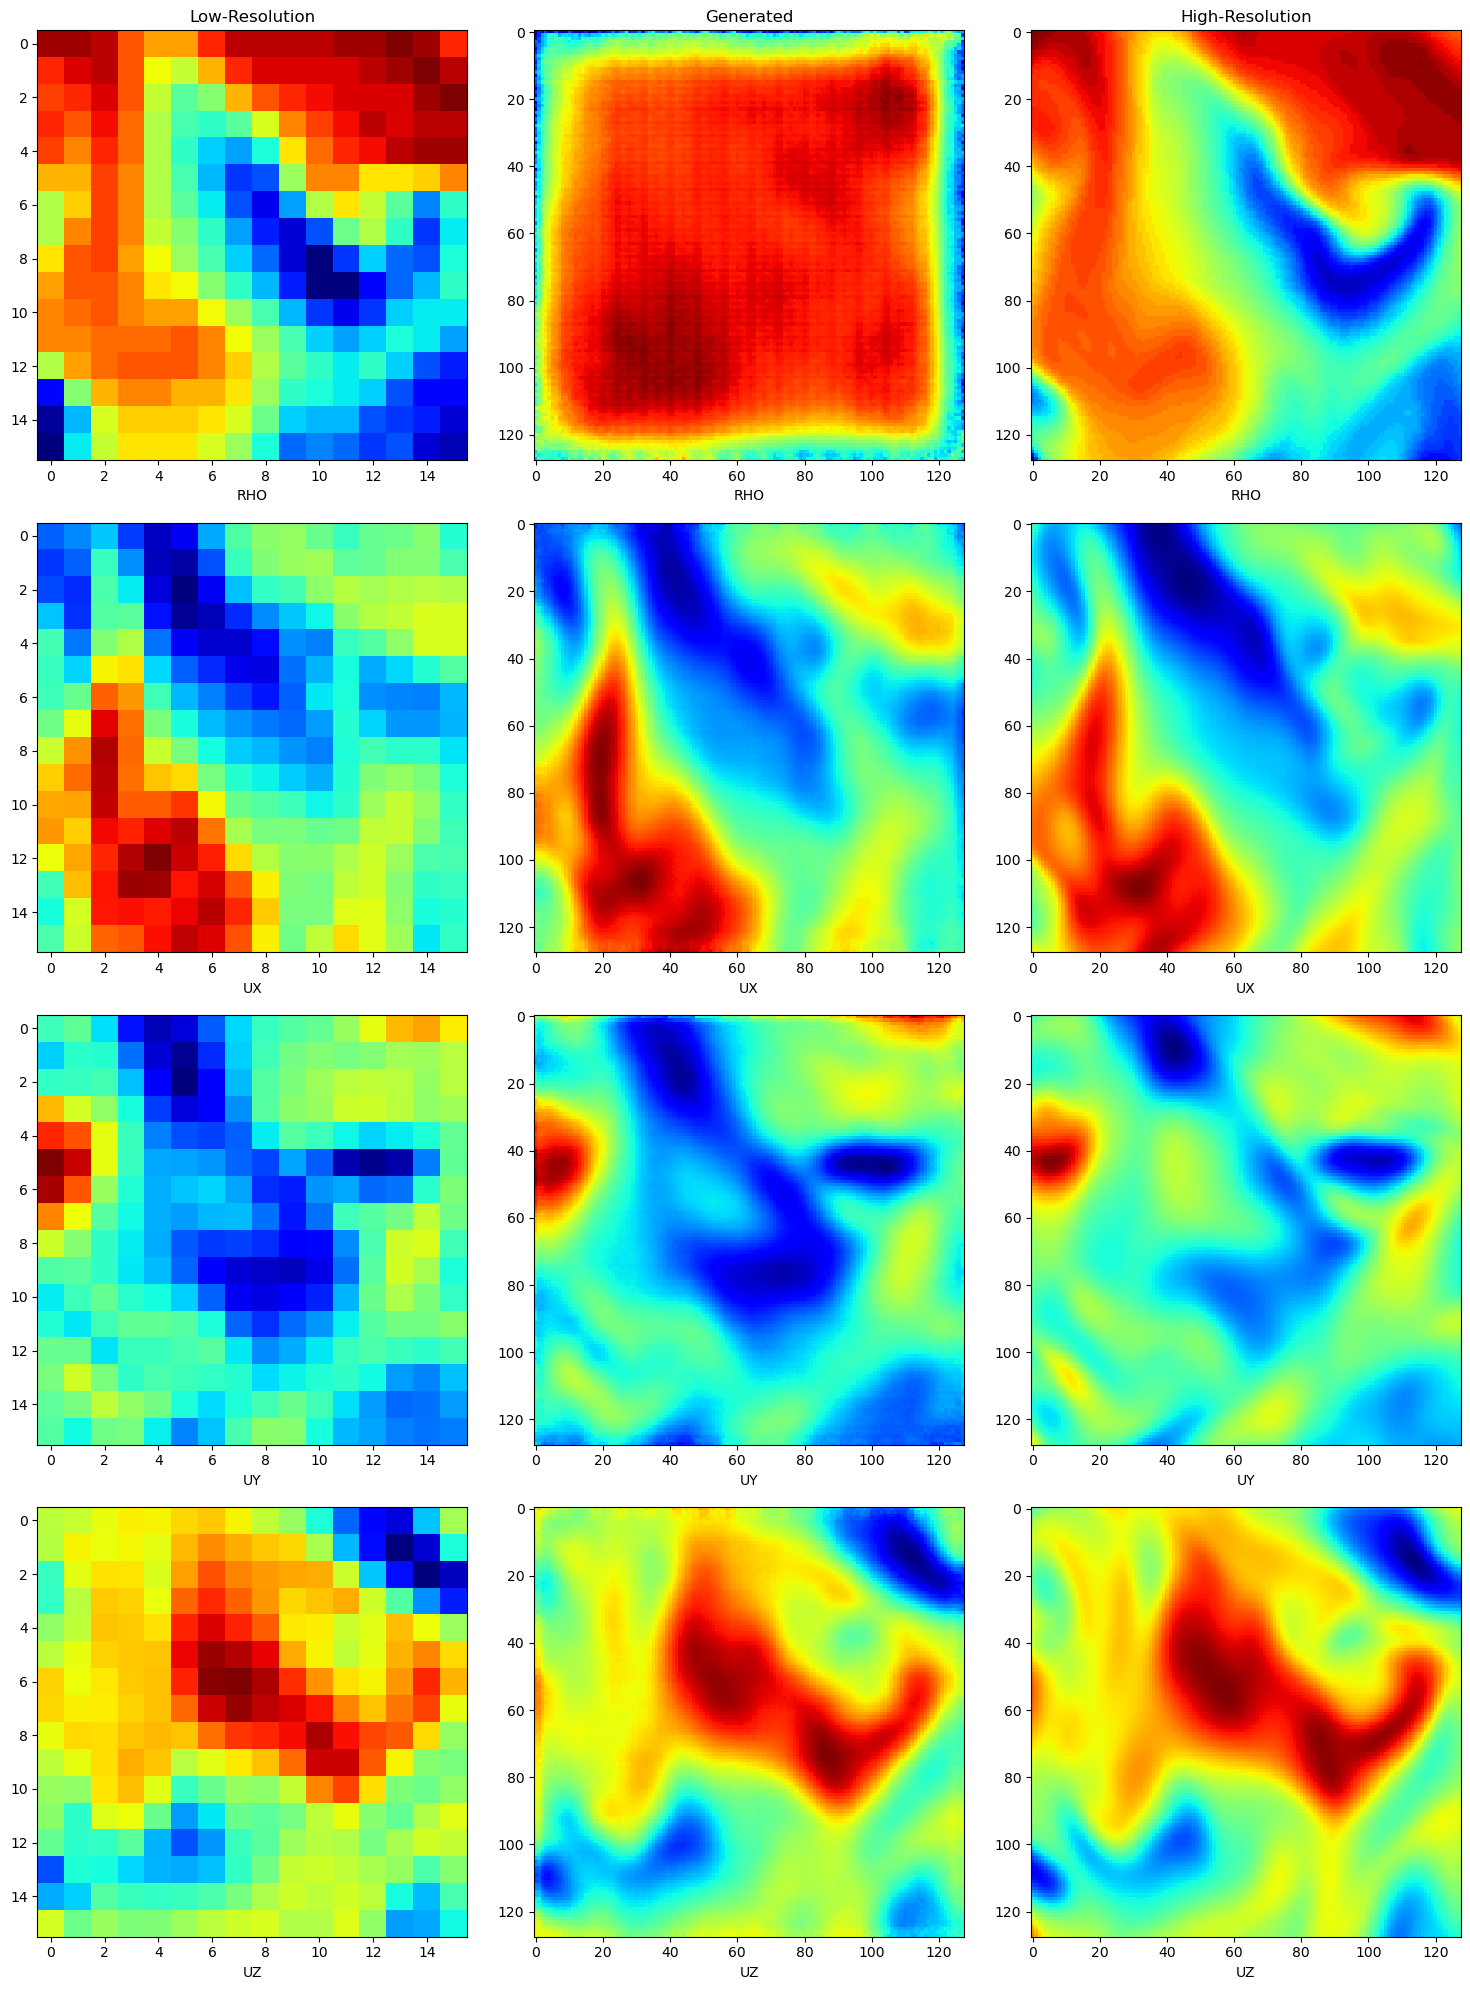


Epoch 251/300
Batch N of M, Generator Loss: 0.0597, Discriminator Loss: 0.9030, MSE: 0.0110, SSIM: 0.0586INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


New best model saved at /Users/federicatonti/Desktop/working_GAN/best_model

Validation Results - Generator Loss: 0.0826, Discriminator Loss: 1.1398, MSE: 0.0097, SSIM: 0.0857

Epoch 252/300
Batch N of M, Generator Loss: 0.0965, Discriminator Loss: 0.4046, MSE: 0.0115, SSIM: 0.0988INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


New best model saved at /Users/federicatonti/Desktop/working_GAN/best_model

Validation Results - Generator Loss: 0.0811, Discriminator Loss: 0.9237, MSE: 0.0099, SSIM: 0.0840

Epoch 253/300
Batch N of M, Generator Loss: 0.0949, Discriminator Loss: 0.8426, MSE: 0.0115, SSIM: 0.0991INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


New best model saved at /Users/federicatonti/Desktop/working_GAN/best_model

Validation Results - Generator Loss: 0.0824, Discriminator Loss: 1.3076, MSE: 0.0098, SSIM: 0.0866

Epoch 254/300
Batch N of M, Generator Loss: 0.1470, Discriminator Loss: 0.4539, MSE: 0.0137, SSIM: 0.1606INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


New best model saved at /Users/federicatonti/Desktop/working_GAN/best_model

Validation Results - Generator Loss: 0.0832, Discriminator Loss: 1.6489, MSE: 0.0091, SSIM: 0.0868

Epoch 255/300
Batch N of M, Generator Loss: 0.1657, Discriminator Loss: 0.6415, MSE: 0.0214, SSIM: 0.1733INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


New best model saved at /Users/federicatonti/Desktop/working_GAN/best_model

Validation Results - Generator Loss: 0.0822, Discriminator Loss: 1.0951, MSE: 0.0091, SSIM: 0.0861

Epoch 256/300
Batch N of M, Generator Loss: 0.1344, Discriminator Loss: 0.2388, MSE: 0.0129, SSIM: 0.1462INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


New best model saved at /Users/federicatonti/Desktop/working_GAN/best_model

Validation Results - Generator Loss: 0.0799, Discriminator Loss: 0.8129, MSE: 0.0092, SSIM: 0.0837

Epoch 257/300
Batch N of M, Generator Loss: 0.0938, Discriminator Loss: 0.7795, MSE: 0.0180, SSIM: 0.0895INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


New best model saved at /Users/federicatonti/Desktop/working_GAN/best_model

Validation Results - Generator Loss: 0.0801, Discriminator Loss: 1.4233, MSE: 0.0094, SSIM: 0.0840

Epoch 258/300
Batch N of M, Generator Loss: 0.0923, Discriminator Loss: 0.8870, MSE: 0.0088, SSIM: 0.0980
Epoch 258: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Validation Results - Generator Loss: 0.0970, Discriminator Loss: 2.2029, MSE: 0.0159, SSIM: 0.0954

Epoch 259/300
Batch N of M, Generator Loss: 0.1355, Discriminator Loss: 0.4261, MSE: 0.0179, SSIM: 0.1370INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


New best model saved at /Users/federicatonti/Desktop/working_GAN/best_model

Validation Results - Generator Loss: 0.0809, Discriminator Loss: 1.2521, MSE: 0.0092, SSIM: 0.0841

Epoch 260/300
Batch N of M, Generator Loss: 0.0861, Discriminator Loss: 0.3566, MSE: 0.0147, SSIM: 0.0848INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


New best model saved at /Users/federicatonti/Desktop/working_GAN/best_model

Validation Results - Generator Loss: 0.0801, Discriminator Loss: 1.2084, MSE: 0.0090, SSIM: 0.0839

Epoch 261/300
Batch N of M, Generator Loss: 0.0891, Discriminator Loss: 0.4839, MSE: 0.0074, SSIM: 0.0981INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


New best model saved at /Users/federicatonti/Desktop/working_GAN/best_model

Validation Results - Generator Loss: 0.0813, Discriminator Loss: 1.1204, MSE: 0.0094, SSIM: 0.0851

Epoch 262/300
Batch N of M, Generator Loss: 0.1038, Discriminator Loss: 0.2649, MSE: 0.0120, SSIM: 0.1089INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


New best model saved at /Users/federicatonti/Desktop/working_GAN/best_model

Validation Results - Generator Loss: 0.0824, Discriminator Loss: 1.3213, MSE: 0.0093, SSIM: 0.0860

Epoch 263/300
Batch N of M, Generator Loss: 0.0354, Discriminator Loss: 1.3427, MSE: 0.0044, SSIM: 0.0376
Validation Results - Generator Loss: 0.0831, Discriminator Loss: 1.5938, MSE: 0.0103, SSIM: 0.0851

Epoch 264/300
Batch N of M, Generator Loss: 0.0414, Discriminator Loss: 0.5174, MSE: 0.0023, SSIM: 0.0454INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


New best model saved at /Users/federicatonti/Desktop/working_GAN/best_model

Validation Results - Generator Loss: 0.0812, Discriminator Loss: 1.0262, MSE: 0.0094, SSIM: 0.0842

Epoch 265/300
Batch N of M, Generator Loss: 0.0784, Discriminator Loss: 1.3758, MSE: 0.0061, SSIM: 0.0868INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


New best model saved at /Users/federicatonti/Desktop/working_GAN/best_model

Validation Results - Generator Loss: 0.0802, Discriminator Loss: 2.1970, MSE: 0.0097, SSIM: 0.0843

Epoch 266/300
Batch N of M, Generator Loss: 0.0835, Discriminator Loss: 0.3938, MSE: 0.0079, SSIM: 0.0905INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


New best model saved at /Users/federicatonti/Desktop/working_GAN/best_model

Validation Results - Generator Loss: 0.0791, Discriminator Loss: 0.8407, MSE: 0.0089, SSIM: 0.0824

Epoch 267/300
Batch N of M, Generator Loss: 0.0304, Discriminator Loss: 0.4049, MSE: 0.0031, SSIM: 0.0300INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


New best model saved at /Users/federicatonti/Desktop/working_GAN/best_model

Validation Results - Generator Loss: 0.0833, Discriminator Loss: 0.8531, MSE: 0.0099, SSIM: 0.0860

Epoch 268/300
Batch N of M, Generator Loss: 0.0248, Discriminator Loss: 0.6894, MSE: 0.0021, SSIM: 0.0262
Epoch 268: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


New best model saved at /Users/federicatonti/Desktop/working_GAN/best_model

Validation Results - Generator Loss: 0.0813, Discriminator Loss: 0.9820, MSE: 0.0096, SSIM: 0.0848

Epoch 269/300
Batch N of M, Generator Loss: 0.0800, Discriminator Loss: 0.5434, MSE: 0.0054, SSIM: 0.0882
Validation Results - Generator Loss: 0.0854, Discriminator Loss: 0.9681, MSE: 0.0116, SSIM: 0.0875

Epoch 270/300
Batch N of M, Generator Loss: 0.0683, Discriminator Loss: 1.1999, MSE: 0.0080, SSIM: 0.0749INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


New best model saved at /Users/federicatonti/Desktop/working_GAN/best_model

Validation Results - Generator Loss: 0.0788, Discriminator Loss: 1.4451, MSE: 0.0091, SSIM: 0.0832

Epoch 271/300
Batch N of M, Generator Loss: 0.1012, Discriminator Loss: 0.3128, MSE: 0.0139, SSIM: 0.1024INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


New best model saved at /Users/federicatonti/Desktop/working_GAN/best_model

Validation Results - Generator Loss: 0.0832, Discriminator Loss: 0.9174, MSE: 0.0097, SSIM: 0.0856

Epoch 272/300
Batch N of M, Generator Loss: 0.0646, Discriminator Loss: 0.9928, MSE: 0.0095, SSIM: 0.0664INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


New best model saved at /Users/federicatonti/Desktop/working_GAN/best_model

Validation Results - Generator Loss: 0.0808, Discriminator Loss: 1.5925, MSE: 0.0097, SSIM: 0.0846

Epoch 273/300
Batch N of M, Generator Loss: 0.0669, Discriminator Loss: 0.6203, MSE: 0.0058, SSIM: 0.0708INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


New best model saved at /Users/federicatonti/Desktop/working_GAN/best_model

Validation Results - Generator Loss: 0.0809, Discriminator Loss: 1.2883, MSE: 0.0100, SSIM: 0.0839

Epoch 274/300
Batch N of M, Generator Loss: 0.0448, Discriminator Loss: 0.3146, MSE: 0.0054, SSIM: 0.0429INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


New best model saved at /Users/federicatonti/Desktop/working_GAN/best_model

Validation Results - Generator Loss: 0.0832, Discriminator Loss: 0.6362, MSE: 0.0087, SSIM: 0.0874

Epoch 275/300
Batch N of M, Generator Loss: 0.0846, Discriminator Loss: 0.4376, MSE: 0.0105, SSIM: 0.0858
Validation Results - Generator Loss: 0.0879, Discriminator Loss: 1.5251, MSE: 0.0096, SSIM: 0.0924

Epoch 276/300
Batch N of M, Generator Loss: 0.0521, Discriminator Loss: 0.6768, MSE: 0.0031, SSIM: 0.0581INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


New best model saved at /Users/federicatonti/Desktop/working_GAN/best_model

Validation Results - Generator Loss: 0.0822, Discriminator Loss: 1.4482, MSE: 0.0097, SSIM: 0.0858

Epoch 277/300
Batch N of M, Generator Loss: 0.0587, Discriminator Loss: 0.9299, MSE: 0.0079, SSIM: 0.0618INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


New best model saved at /Users/federicatonti/Desktop/working_GAN/best_model

Validation Results - Generator Loss: 0.0818, Discriminator Loss: 1.2184, MSE: 0.0096, SSIM: 0.0848

Epoch 278/300
Batch N of M, Generator Loss: 0.1049, Discriminator Loss: 0.5100, MSE: 0.0214, SSIM: 0.1058
Epoch 278: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Validation Results - Generator Loss: 0.0844, Discriminator Loss: 1.0784, MSE: 0.0109, SSIM: 0.0881

Epoch 279/300
Batch N of M, Generator Loss: 0.1507, Discriminator Loss: 0.5410, MSE: 0.0237, SSIM: 0.1503
Validation Results - Generator Loss: 0.0964, Discriminator Loss: 1.3689, MSE: 0.0140, SSIM: 0.0969

Epoch 280/300
Batch N of M, Generator Loss: 0.0871, Discriminator Loss: 1.1268, MSE: 0.0091, SSIM: 0.0941
Validation Results - Generator Loss: 0.0811, Discriminator Loss: 1.6622, MSE: 0.0100, SSIM: 0.0839

Epoch 281/300
Batch N of M, Generator Loss: 0.0950, Discriminator Loss: 0.2841, MSE: 0.0081, SSIM: 0.1017INFO:tensorflow:Asset

INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


New best model saved at /Users/federicatonti/Desktop/working_GAN/best_model

Validation Results - Generator Loss: 0.0818, Discriminator Loss: 1.0628, MSE: 0.0099, SSIM: 0.0840

Epoch 282/300
Batch N of M, Generator Loss: 0.1157, Discriminator Loss: 0.6017, MSE: 0.0118, SSIM: 0.1197
Validation Results - Generator Loss: 0.0865, Discriminator Loss: 1.6665, MSE: 0.0122, SSIM: 0.0867

Epoch 283/300
Batch N of M, Generator Loss: 0.1220, Discriminator Loss: 0.4517, MSE: 0.0094, SSIM: 0.1323INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


New best model saved at /Users/federicatonti/Desktop/working_GAN/best_model

Validation Results - Generator Loss: 0.0800, Discriminator Loss: 1.9124, MSE: 0.0095, SSIM: 0.0831

Epoch 284/300
Batch N of M, Generator Loss: 0.0297, Discriminator Loss: 0.5072, MSE: 0.0025, SSIM: 0.0316INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


New best model saved at /Users/federicatonti/Desktop/working_GAN/best_model

Validation Results - Generator Loss: 0.0832, Discriminator Loss: 1.2038, MSE: 0.0100, SSIM: 0.0858

Epoch 285/300
Batch N of M, Generator Loss: 0.1485, Discriminator Loss: 0.3718, MSE: 0.0212, SSIM: 0.1500INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


New best model saved at /Users/federicatonti/Desktop/working_GAN/best_model

Validation Results - Generator Loss: 0.0807, Discriminator Loss: 1.5193, MSE: 0.0092, SSIM: 0.0843

Epoch 286/300
Batch N of M, Generator Loss: 0.1793, Discriminator Loss: 0.1168, MSE: 0.0218, SSIM: 0.1747INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


New best model saved at /Users/federicatonti/Desktop/working_GAN/best_model

Validation Results - Generator Loss: 0.0832, Discriminator Loss: 1.9917, MSE: 0.0097, SSIM: 0.0843

Epoch 287/300
Batch N of M, Generator Loss: 0.1682, Discriminator Loss: 0.3239, MSE: 0.0278, SSIM: 0.1732
Validation Results - Generator Loss: 0.0942, Discriminator Loss: 1.2655, MSE: 0.0134, SSIM: 0.0962

Epoch 288/300
Batch N of M, Generator Loss: 0.0623, Discriminator Loss: 0.4433, MSE: 0.0057, SSIM: 0.0680
Epoch 288: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


New best model saved at /Users/federicatonti/Desktop/working_GAN/best_model

Validation Results - Generator Loss: 0.0817, Discriminator Loss: 1.2906, MSE: 0.0095, SSIM: 0.0849

Epoch 289/300
Batch N of M, Generator Loss: 0.0873, Discriminator Loss: 0.2805, MSE: 0.0077, SSIM: 0.0919INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


New best model saved at /Users/federicatonti/Desktop/working_GAN/best_model

Validation Results - Generator Loss: 0.0827, Discriminator Loss: 1.0371, MSE: 0.0098, SSIM: 0.0854

Epoch 290/300
Batch N of M, Generator Loss: 0.0590, Discriminator Loss: 1.1287, MSE: 0.0066, SSIM: 0.0627
Validation Results - Generator Loss: 0.0859, Discriminator Loss: 1.8268, MSE: 0.0107, SSIM: 0.0887

Epoch 291/300
Batch N of M, Generator Loss: 0.0709, Discriminator Loss: 0.4372, MSE: 0.0059, SSIM: 0.0754INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


New best model saved at /Users/federicatonti/Desktop/working_GAN/best_model

Validation Results - Generator Loss: 0.0799, Discriminator Loss: 2.0508, MSE: 0.0088, SSIM: 0.0822

Epoch 292/300
Batch N of M, Generator Loss: 0.0331, Discriminator Loss: 0.7658, MSE: 0.0026, SSIM: 0.0352INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


New best model saved at /Users/federicatonti/Desktop/working_GAN/best_model

Validation Results - Generator Loss: 0.0800, Discriminator Loss: 1.5308, MSE: 0.0100, SSIM: 0.0825

Epoch 293/300
Batch N of M, Generator Loss: 0.0376, Discriminator Loss: 0.5777, MSE: 0.0025, SSIM: 0.0424INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


New best model saved at /Users/federicatonti/Desktop/working_GAN/best_model

Validation Results - Generator Loss: 0.0811, Discriminator Loss: 1.3806, MSE: 0.0099, SSIM: 0.0837

Epoch 294/300
Batch N of M, Generator Loss: 0.0502, Discriminator Loss: 0.6835, MSE: 0.0051, SSIM: 0.0525
Validation Results - Generator Loss: 0.0818, Discriminator Loss: 1.3972, MSE: 0.0104, SSIM: 0.0840

Epoch 295/300
Batch N of M, Generator Loss: 0.0495, Discriminator Loss: 0.7972, MSE: 0.0066, SSIM: 0.0516INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


New best model saved at /Users/federicatonti/Desktop/working_GAN/best_model

Validation Results - Generator Loss: 0.0803, Discriminator Loss: 1.7848, MSE: 0.0097, SSIM: 0.0833

Epoch 296/300
Batch N of M, Generator Loss: 0.1087, Discriminator Loss: 0.4911, MSE: 0.0151, SSIM: 0.1062INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


New best model saved at /Users/federicatonti/Desktop/working_GAN/best_model

Validation Results - Generator Loss: 0.0813, Discriminator Loss: 1.7804, MSE: 0.0098, SSIM: 0.0842

Epoch 297/300
Batch N of M, Generator Loss: 0.0695, Discriminator Loss: 0.9232, MSE: 0.0065, SSIM: 0.0765INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


New best model saved at /Users/federicatonti/Desktop/working_GAN/best_model

Validation Results - Generator Loss: 0.0803, Discriminator Loss: 1.8222, MSE: 0.0096, SSIM: 0.0827

Epoch 298/300
Batch N of M, Generator Loss: 0.1351, Discriminator Loss: 0.6583, MSE: 0.0159, SSIM: 0.1419
Epoch 298: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


New best model saved at /Users/federicatonti/Desktop/working_GAN/best_model

Validation Results - Generator Loss: 0.0809, Discriminator Loss: 1.5575, MSE: 0.0092, SSIM: 0.0838

Epoch 299/300
Batch N of M, Generator Loss: 0.0714, Discriminator Loss: 0.6037, MSE: 0.0060, SSIM: 0.0763INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


New best model saved at /Users/federicatonti/Desktop/working_GAN/best_model

Validation Results - Generator Loss: 0.0801, Discriminator Loss: 1.7666, MSE: 0.0092, SSIM: 0.0830

Epoch 300/300
Batch N of M, Generator Loss: 0.0838, Discriminator Loss: 0.5684, MSE: 0.0068, SSIM: 0.0908INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/best_model/assets


New best model saved at /Users/federicatonti/Desktop/working_GAN/best_model

Validation Results - Generator Loss: 0.0776, Discriminator Loss: 1.8323, MSE: 0.0084, SSIM: 0.0804
1/1 [==============================] - 0s 176ms/step
Average SSIM for generated images: 0.898309588432312
Average SSIM for post-processed images: 0.8998520374298096


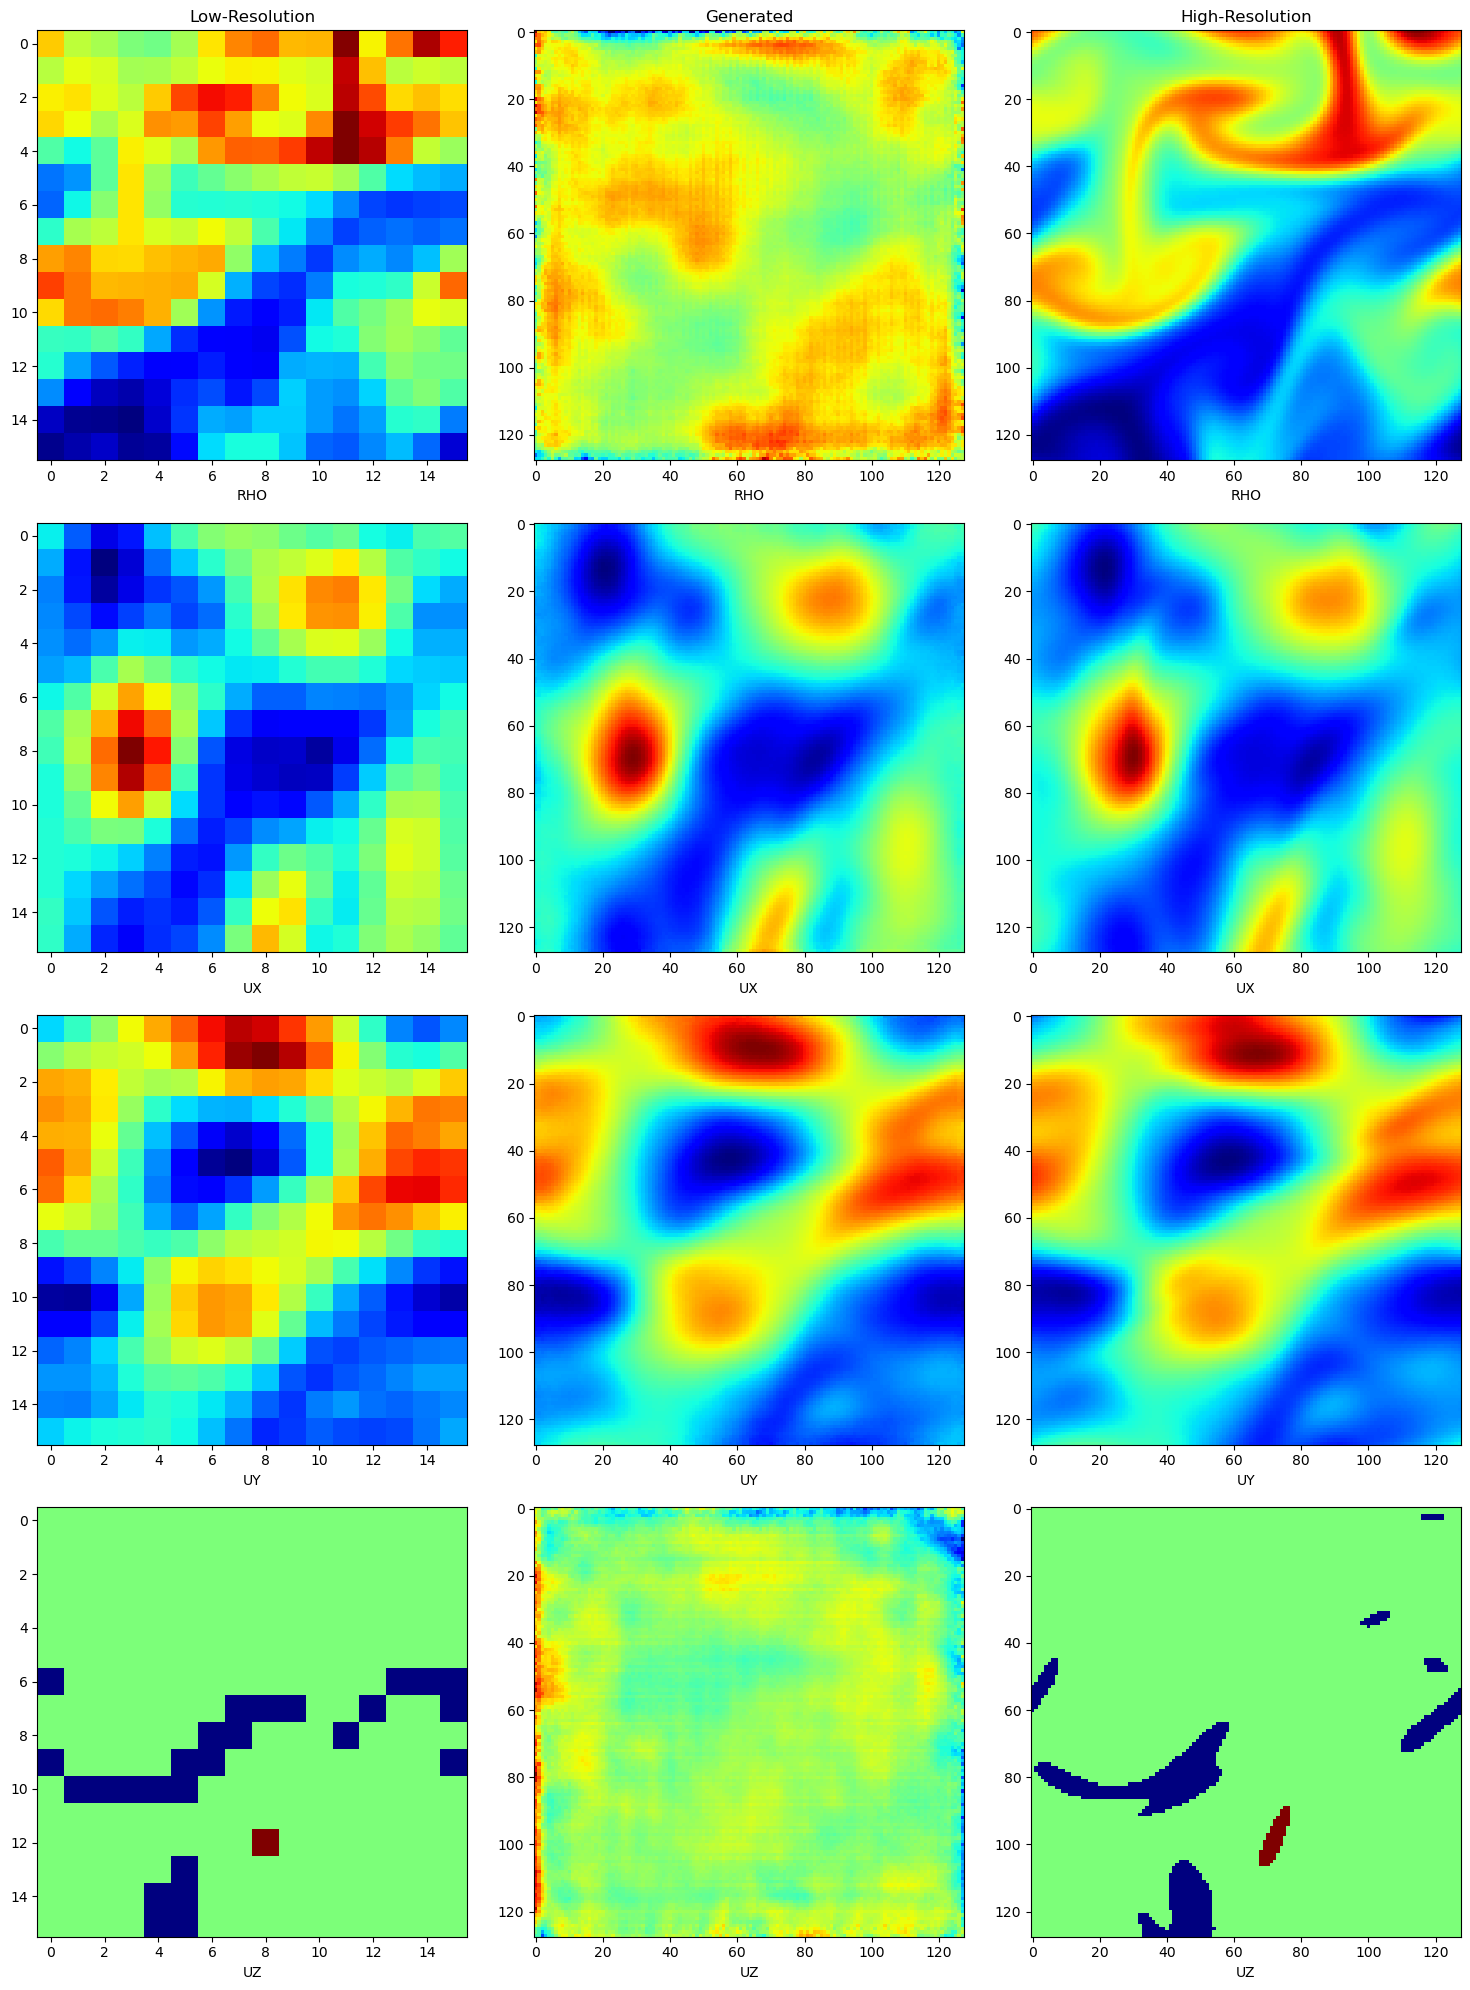

INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/final_model/assets


INFO:tensorflow:Assets written to: /Users/federicatonti/Desktop/working_GAN/final_model/assets


(<keras.src.engine.functional.Functional at 0x296db8820>,
 <keras.src.engine.functional.Functional at 0x29ba23880>)

In [131]:

tf.config.optimizer.set_experimental_options({'layout_optimizer': False})
train(dataset=train_ds, val_dataset=val_ds, epochs=300, generator=generator, discriminator=discriminator, gen_optimizer=gen_optimizer, disc_optimizer=disc_optimizer, disc_train_ratio=2, checkpoint=checkpoint, checkpoint_prefix=checkpoint_prefix, callbacks=callbacks)


In [132]:
# define means and std to weigh density and velocity predictions to a similar range before MSE metric
my_mean = [0.24,28.0, 28.0, 28.0]
my_std = [0.068,48.0, 48.0, 48.0]
my_mean = np.array(my_mean)
my_std = np.array(my_std)

test_df = pd.read_csv(input_path+'/test.csv')
test_df.head()

,id,dx_m,rho_filename,ux_filename,uy_filename,uz_filename
0,-657116647631363807,0.000041,RHO_kgm-3_id-657116647631363807.dat,UX_ms-1_id-657116647631363807.dat,UY_ms-1_id-657116647631363807.dat,UZ_ms-1_id-657116647631363807.dat
1,7483162365939134796,0.000041,RHO_kgm-3_id7483162365939134796.dat,UX_ms-1_id7483162365939134796.dat,UY_ms-1_id7483162365939134796.dat,UZ_ms-1_id7483162365939134796.dat
2,-6212758420087317096,0.000041,RHO_kgm-3_id-6212758420087317096.dat,UX_ms-1_id-6212758420087317096.dat,UY_ms-1_id-6212758420087317096.dat,UZ_ms-1_id-6212758420087317096.dat
3,-1825935182480952214,0.000041,RHO_kgm-3_id-1825935182480952214.dat,UX_ms-1_id-1825935182480952214.dat,UY_ms-1_id-1825935182480952214.dat,UZ_ms-1_id-1825935182480952214.dat
4,-1859240836295259171,0.000015,RHO_kgm-3_id-1859240836295259171.dat,UX_ms-1_id-1859240836295259171.dat,UY_ms-1_id-1859240836295259171.dat,UZ_ms-1_id-1859240836295259171.dat


In [143]:
#gets test set input
def getTestX(idx):
    csv_file = test_df.reset_index().to_dict(orient='list')
    LR_path = input_path+"flowfields/LR/test" 
    id = csv_file['id'][idx]

    rho_i = np.fromfile(LR_path + "/" + csv_file['rho_filename'][idx], dtype="<f4").reshape(16,16)
    ux_i = np.fromfile(LR_path + "/" + csv_file['ux_filename'][idx], dtype="<f4").reshape(16,16)
    uy_i = np.fromfile(LR_path + "/" + csv_file['uy_filename'][idx], dtype="<f4").reshape(16,16)
    uz_i = np.fromfile(LR_path + "/" + csv_file['uz_filename'][idx], dtype="<f4").reshape(16,16)
    
    X = tf.stack([rho_i,ux_i,uy_i,uz_i],axis=2)
    return id,X

def scale_X(X,my_mean=my_mean,my_std=my_std):
    Xscaled = (X-my_mean)/my_std
    return Xscaled

#predicts with input
def predict(idx,model):
    id,X = getTestX(idx)
    X = tf.expand_dims(X,0)
    X = scale_X(X)
    y_pred = model.predict(X)
    #added this to rescale predictions CHANGE THIS IF YOU USED DIFFERENT SCALING
    y_pred_unscaled = (y_pred*my_std)+my_mean
    return id,y_pred_unscaled

#generates submission with model predictions already in SI units
def generate_submission(model):
    my_mean = [0.24,28.0, 28.0, 28.0]
    my_std = [0.068,48.0, 48.0, 48.0]
    my_mean = np.array(my_mean)
    my_std = np.array(my_std)
    y_preds = {}
    ids = []
    for idx in range(len(test_df)):
        id,y_pred = predict(idx,model) 
        #WARNING tmp should be in SI units
        tmp = (np.array(y_pred) - my_mean)/my_std #this normalizes density and velocity to be in the same range
        y_preds[id]= np.array(tmp).flatten(order='C').astype(np.float32)
        ids.append(id)
    df = pd.DataFrame.from_dict(y_preds,orient='index')
    df['id'] = ids
    #move id to first column
    cols = df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df = df[cols]
    #reset index
    df = df.reset_index(drop=True)

    return df





In [142]:
import tensorflow as tf
import os
input_path = '/Users/federicatonti/Desktop/dataset/'
output_path = '/Users/federicatonti/Desktop/working_GAN'
# Load the saved model
best_model_path = os.path.join(output_path, "best_model")  # Path where your best model is saved
model = tf.keras.models.load_model(final_model_path, custom_objects=custom_objs)
generator.compile(optimizer=gen_optimizer, loss=custom_objs['generator_loss'], metrics=['mse', custom_objs['ssim_loss']])
discriminator.compile(optimizer=disc_optimizer, loss=custom_objs['discriminator_loss'], metrics=['accuracy', 'mse', custom_objs['ssim_loss']])
model = tf.keras.models.load_model(best_model_path, custom_objects=custom_objs)


# Now use the model to make predictions on the test set
submission_df = generate_submission(model)
submission_df.to_csv(output_path + '_submission.csv', index=False)
submission_df.head()


2023-09-18 03:55:43.837906: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 20ms/step


,id,0,1,2,3,4,5,6,7,8,...,65526,65527,65528,65529,65530,65531,65532,65533,65534,65535
0,-657116647631363807,0.974384,0.962964,-0.554129,-0.517203,0.988679,0.972492,-0.558094,-0.534092,0.986353,...,-0.630868,-0.614672,1.001992,0.928985,-0.632699,-0.607881,1.002143,0.948654,-0.645336,-0.616043
1,7483162365939134796,0.954589,0.721687,-0.586989,-0.559226,0.975621,0.750437,-0.586382,-0.565345,0.981458,...,-0.455888,-0.484759,0.924427,0.323283,-0.438017,-0.500412,0.919316,0.335676,-0.450945,-0.500878
2,-6212758420087317096,0.975981,0.666740,-0.586823,-0.533813,0.990267,0.679069,-0.586583,-0.545816,0.988756,...,-0.606892,-0.590911,0.995160,0.852971,-0.609741,-0.587907,0.995931,0.866319,-0.620410,-0.598171
3,-1825935182480952214,-0.900452,1.181535,-0.325943,-1.067743,-0.860266,1.146689,-0.336717,-1.055179,-0.849383,...,-0.910119,-1.366356,-0.954817,1.754391,-0.912075,-1.429421,-0.991444,1.766327,-0.969374,-1.508601
4,-1859240836295259171,2.431729,-0.565062,-0.490580,-0.502366,2.481418,-0.529677,-0.492417,-0.517733,2.478044,...,-0.368229,-0.713713,1.027520,-0.354136,-0.333696,-0.729998,1.027840,-0.351627,-0.370818,-0.735141


In [141]:
import matplotlib.pyplot as plt

def visualize_predictions(model, num_samples=5):
    # Choose a random set of indices from the training set
    indices = np.random.choice(len(train_df), num_samples)

    for idx in indices:
        # Get predictions and actual values
        _, y_pred = predict_train(idx, model)
        _, y_actual = getTrainXY(idx)

        # For demonstration, let's plot the first channel (e.g., 'rho')
        # Adjust the index '0' to visualize other channels
        pred_channel = y_pred[0][:, :, 0]
        actual_channel = y_actual.numpy()[:, :, 0]

        # Plot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        ax1.imshow(pred_channel, cmap='viridis', origin='lower')
        ax1.set_title(f'Prediction for Sample {idx}')
        ax2.imshow(actual_channel, cmap='viridis', origin='lower')
        ax2.set_title(f'Actual for Sample {idx}')
        
        plt.show()
        
final_model_path = os.path.join(output_path, "best_model")
model = tf.keras.models.load_model(final_model_path)
# To visualize:
visualize_predictions(model, num_samples=5)


ValueError: Unable to restore custom object of class "MeanMetricWrapper" (type _tf_keras_metric). Please make sure that this class is included in the `custom_objects` arg when calling `load_model()`. Also, check that the class implements `get_config` and `from_config`.

Complete metadata: {'class_name': 'MeanMetricWrapper', 'name': 'ssim_loss', 'dtype': 'float32', 'config': {'name': 'ssim_loss', 'dtype': 'float32'}, 'shared_object_id': 533}